<a href="https://colab.research.google.com/github/taomasgonzalez/Electrocardiogram-RLS/blob/master/Notebook/Electrocardiogram_RLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectando anomalías en Electrocardiogramas (ECG)

## Imports

Instalamos las librerías necesarias

In [47]:
!pip install wfdb
!pip install padasip

Importamos las librerías necesarias

In [0]:
# https://github.com/MIT-LCP/wfdb-python
# https://wfdb.readthedocs.io/en/latest/
import numpy as np
import wfdb
import matplotlib.pyplot as plt
import padasip as pa
from scipy import signal as scsig
from scipy.signal import detrend
from scipy.signal import find_peaks
import pandas as pd

Clonamos el repositorio de github:

In [49]:
!git clone "https://github.com/taomasgonzalez/Electrocardiogram-LMS.git"

fatal: destination path 'Electrocardiogram-LMS' already exists and is not an empty directory.


## Obtención de los datos

Obtenemos los datos de electrocardiogramas realizados a múltiples pacientes del MIT-BIH Arrhythmia Database (https://physionet.org/content/mitdb/1.0.0/).

Para más información sobre su contenido y las particularidades con las que los datos fueron obtenidos, visitar la página.

### Definición de funciones de obtención de datos del dataset

In [0]:
def get_data(file_path, sampto='end'):
  """
  get_data devuelve las señales del primer y segundo canal de un archivo que cumple con el estándar wfdb,
  la metadata del mismo y las anotaciones del mismo en caso de haberlas (archivo con el mismo nombre pero con extensión .atr)
  
  Parámetros:
    file_path: path del archivo de donde conseguir las señales a leer.
    sampto: cantidad de samples a leer. Si 'end', lee todas las samples del archivo.
  Returns:
    signal_0: Señal del primer canal.
    signal_1: Señal del segundo canal.
    metadata: metadata que contiene, entre otras cosas, la sample frequency utilizada para tomar los datos.
    annotation: anotaciones correspondientes al archivo
  """
  # Cada columna de la matriz signals es un canal de las señales grabadas del paciente(signals[0] es el primer canal)
  # metadata tiene información como la sample frequency, importante para el resto del trabajo.
  signals, metadata = wfdb.rdsamp(record_name=file_path, sampto=sampto)
  annotation = wfdb.rdann(record_name=file_path, extension='atr', sampto=sampto)
  
  return signals[:,0], signals[:,1], metadata, annotation

### Obtención de las señales

Definimos los archivos están presentes en dataset, que serán los archivos que extraeremos

In [0]:
all_signals = {str(i): dict() for j in (range(100, 125), range(200, 224)) for i in j}
# borramos del dictionary a los archivos que no estan pero que fueron agregados por comodidad
for i in ['110', '120', '204','206','211','216','218']: del all_signals[i]   
all_signals['228'] = None
for i in range(230,235) : all_signals[str(i)] = None

Obtenemos las señales de cada canal, en conjunto con su metadata y las anotaciones que corresponden a la presencia de anomalía o no.

In [0]:
for signal_name in all_signals.keys():
  upper_signal, lower_signal, metadata, annotations =  get_data(file_path='/content/Electrocardiogram-LMS/data/' + signal_name,sampto=None)
  all_signals[signal_name] = {'upper' : upper_signal, 'lower' : lower_signal, 'meta':metadata, 'annot': annotations} 

Visualizamos alguna de las señales:

Hacemos un plot de los primeros 1000 samples de una de las señales de uno de los pacientes

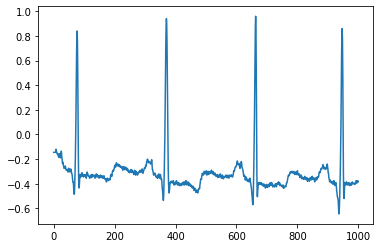

In [53]:
plt.plot(all_signals[list(all_signals.keys())[0]]['upper'][:1000])

### Anotaciones

Visualizamos la clase anotaciones, cómo está estructurada internamente.


In [54]:
anot = all_signals[list(all_signals.keys())[0]]['annot']
attrs = vars(anot)
print ('\n'.join("%s: %s" % item for item in attrs.items()))

record_name: 100
extension: atr
sample: [    18     77    370 ... 649484 649734 649991]
symbol: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'

Cambiamos todas las anotaciones a un formato binario de tipo "anómala" ('A') o "no anómala" ('N'). 
Visualizamos luego el resultado de un fragmento de una señal de un paciente.

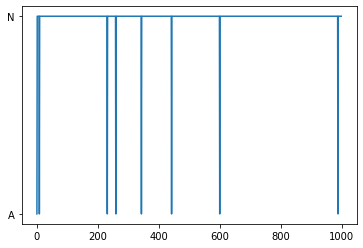

In [55]:
for key in all_signals.keys():
  anot = all_signals[key]['annot']
  anot.symbol = ['A' if i is not 'N' else 'N' for i in anot.symbol]
  # guardamos el sample en el que se produce la anomalia y el indice de la misma en el anot.sample 
  all_signals[key]['anomalies'] = {anot.sample[i] : i  for i in range(len(anot.symbol)) if anot.symbol[i] is 'A'}
  # guardamos el sample en el que se produce la anotacion normal y el indice de la misma en el anot.sample 
  all_signals[key]['not_anomalies'] = {anot.sample[i] : i  for i in range(len(anot.symbol)) if anot.symbol[i] is 'N'}
   
anot = all_signals[list(all_signals.keys())[0]]['annot']
plt.plot(anot.symbol[0:1000])

### Eliminación de ruido

El ruido principal que afectará al comportamiento del filtro a implementar es aquel que produce al baseline wonder, además del ruido de línea. Se elimina el ruido de baja frecuencia aplicando un pasaltos de frecuencia apropiada (0.1 Hz).

In [0]:
def noise_filtering(signal):
    b, a = scsig.butter(4, 0.1 * 2 * np.pi, btype='highpass', fs=360)
    return scsig.filtfilt(b, a, original)

## Implementación del filtro adaptativo

### Implementación del filtro

In [0]:
# https://matousc89.github.io/padasip/sources/filters/lms.html#references
# https://matousc89.github.io/padasip/_modules/padasip/filters/lms.html#FilterLMS
class FilterLMS():
    """
    This class represents an adaptive LMS filter.

    **Args:**

    * `n` : length of filter (integer) - how many input is input array
      (row of input matrix)

    **Kwargs:**

    * `mu` : learning rate (float). Also known as step size. If it is too slow,
      the filter may have bad performance. If it is too high,
      the filter will be unstable. The default value can be unstable
      for ill-conditioned input data.

    * `w` : initial weights of filter. Possible values are:
        
        * array with initial weights (1 dimensional array) of filter size
    
        * "random" : create random weights
        
        * "zeros" : create zero value weights
    """
    
    def __init__(self, n, w='zeros', mu=0.01):
        self.n = n
        self.mu = mu
        if w is 'zeros':
          self.w = np.zeros(self.n)
        else:  
          if len(w) is self.n: 
            self.w = np.array(w)
          else:
            raise ValueError('The size of filter must be the same as the size of the weights vector')
        
        self.w_history = False
        self.input = np.array([])
        self.desired_response = np.array([])
        self.y = np.array([])
        self.e = np.array([])
        
    def adapt(self, d, x):
        """
        Adapt weights according one desired value and its input.

        **Args:**

        * `d` : desired value (float)

        * `x` : input array (1-dimensional array)
        """
        y = np.dot(self.w, x)
        e = d - y
        self.w += self.mu * e * x        
        return y, e  
      
    def run(self, input_signal, desired_response):
      self.desired_response = desired_response[self.n+1:]
      self.input_signal = input_signal
      self.y = np.array([])
      self.e = np.array([])
      
      for i in range(len(self.desired_response)):
        if i+self.n <= len(self.input_signal):
          y, e = self.adapt(self.desired_response[i], self.input_signal[i:i+self.n])
          self.y = np.concatenate((self.y, np.array([y])), axis=0)
          self.e = np.concatenate((self.e, np.array([e])), axis=0)
        else:
          break
        
      return self.y, self.e

### Control gráfico para el análisis del filtro

In [0]:
def plot_signal_vs_predicted(signal, predicted, error, sampling_size):
  plt.figure(figsize=(15,9))

  last_n_samples = 1000
  plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
  plt.plot(signal[sampling_size-last_n_samples:],"b", label="d - target")
  plt.plot(predicted[sampling_size-last_n_samples:],"g", label="y - output");plt.legend()

  plt.subplot(212);plt.title("Filter error");plt.xlabel("samples - k")
  # plt.plot(10*np.log10(error**2),"r", label="e^2 - squared error [dB]");plt.legend()
  plt.plot(error[sampling_size-last_n_samples:],"r", label="error");plt.legend()

  plt.tight_layout()
  plt.show()

### Prueba del filtro aplicado a los datos

In [0]:
# filter_size = 100
# predictor_filter = FilterLMS(n=filter_size, w='zeros', mu=0.005)
# sampling_size = 300000
# upper_signal = all_signals[list(all_signals.keys())[0]]['upper'][:sampling_size]
# y, e = predictor_filter.run(input_signal=upper_signal, desired_response=upper_signal)
# y = np.append(np.zeros(filter_size), y)

Se grafica para un intervalo sano (sin anomalías)

In [0]:
# plot_signal_vs_predicted(signal=upper_signal, predicted=y, error=e, sampling_size=sampling_size)

Se grafica ahora un intervalo con anomalías

In [0]:
# anot = all_signals[list(all_signals.keys())[0]]['annot']
# selected = anot.sample[np.logical_and(anot.sample > 99000, anot.sample < 100000)]
# anom = all_signals[list(all_signals.keys())[0]]['anomalies']
# for s in selected:
#   if s in anom:
#     first = s-500
#     last = s+500
#     print(first)
#     break
    
# detected = np.arange(len(e[60000:]))[abs(e[60000:]) > 0.485 ]
# print(detected + 60000)
# print(list(all_signals[list(all_signals.keys())[0]]['anomalies'].keys()))
# plt.figure(figsize=(15,9))

# last_n_samples = 1000
# plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
# plt.plot(upper_signal[first:last],"b", label="d - target")
# plt.plot(y[first:last],"g", label="y - output");plt.legend()

# plt.subplot(212);plt.title("Filter error");plt.xlabel("samples - k")
# # plt.plot(10*np.log10(error**2),"r", label="e^2 - squared error [dB]");plt.legend()
# plt.plot(e[first:last],"r", label="error");plt.legend()

# plt.tight_layout()
# plt.show()

## Implementación del detector de anomalías



### Implementación del filtro ARF

Se implementa a continuación el **filtro ARF** (Adaptative recursive filter) para generar la señal de error de predicción que se utilizará para la detección de anomalías.

In [0]:
class filterARF:
    def __init__(self, n, mu):
        self.w = np.zeros(n + 1)
        self.n = n
        self.mu = mu

        self.w[0] = 1

    def train(self, u, d): # entrenamos el filtro con una señal de impulsos y la señal verdadera
        y = np.zeros(len(u))
        e = np.zeros(len(u))

        last_impulse_position = -1

        for i in range(len(u)):
            if i + 1 >= self.n + 1:
                y[i] = np.dot(self.w, np.flip(u[i + 1 - (self.n + 1):i + 1]))
            else:
                y[i] = np.dot(self.w[:i + 1], np.flip(u[:i + 1]))

            if u[i] == 1:
                last_impulse_position = i

            # calculo error
            e[i] = d[i] - y[i]

            # actualizo coeficientes
            if last_impulse_position != -1:
                k = i - last_impulse_position
                if k <= self.n:
                    self.w[k] += 2 * self.mu * e[i]# actualizo coeficiente k-esimo

        return y, e

    def run(self, u, d): # ejecutamos el filtro, obtenemos el error, no actualizamos coeficientes
        y = np.zeros(len(u))
        e = np.zeros(len(u))
        for i in range(len(u)):
            if i + 1 >= self.n + 1:
                y[i] = np.dot(self.w, np.flip(u[i + 1 - (self.n + 1):i + 1]))
            else:
                y[i] = np.dot(self.w[:i + 1], np.flip(u[:i + 1]))

            # calculo error
                e[i] = d[i] - y[i]

        return y, e

### Detector del complejo QRS mediante la detección de los picos R

La detección del complejo QRS servirá para generar la señal de impulsos que será entrada del filtro ARF en conjunto a la señal de ECG original.

In [0]:
def getPeaks(signal, fs, min_distance, impulse_distance = 0):
    """
    signal: samples
    min_distance: distance of peaks
    fs: sample frecuency 
    """
    power_signal = np.power(signal,2)

    # Consideramos que la señal no variara considerablemente en al menos 10 periodos del filtro
    stationarity_size = 10*500

    max_value = max(power_signal[:stationarity_size]) # maximo valor de la potencia en el primer intervalo estacionario

    peakSignal = np.zeros(len(signal)) # señal donde almacenamos los picos

    counter = 0
    impulse_ticks = int(impulse_distance * fs)
    
    for i in range(len(signal)):
      if i % stationarity_size == 0:
        max_value = max(power_signal[:stationarity_size])
      
      if counter > 0:
        counter -= 1
      elif power_signal[i] > max_value * 0.45:
        counter = min_distance * fs
        if i > impulse_ticks:
          peakSignal[i - impulse_ticks] = 1

    return peakSignal

### Probando al ARF

Se busca que la señal de error del ARF tenga picos coincidentes con las anomalías, ya que se utilizará a la misma para la detección de anomalías.

#### Señal de prueba

Se procede a probar el detector usando la señal 202 que tiene un conjunto de señales cardiacas válidas en su inicio.

Extraemos la señal y definimos un tiempo de prueba:

In [0]:
fs = 360
timespan = 400
time_cycle = 1.4
# señal = no_noise_signal
señal = all_signals["202"]["upper"][:timespan*fs]
t = np.arange(len(señal)) / fs
errores = list(all_signals["202"]["anomalies"].keys())
errores = [ float(errores[i]) / fs for i in range(len(errores))]

#### Análisis gráfico de la salida del ARF y contrastación con las anomalías de la base de datos

Se procederá a graficar aquellos valores que deberían ser detectados como anomalías en naranja. Para ello definimos la siguiente funcion:

In [0]:
def anomaly_plotter(axis, anomalies, timespan, min, max):
  for ai in anomalies:
    if ai < timespan:
        axis.plot([ai, ai], [min, max], 'orange')

Analizamos gráficamente los resultados y verificamos que los mismos tienen sentido con los defectos encontrados. 

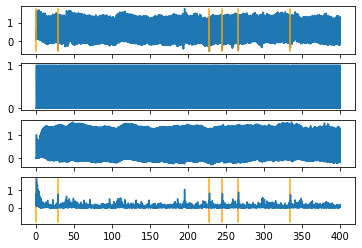

In [65]:
señal = detrend(señal)      # quitamos la tendencia que agrega el ruido de línea y de los movimientos corporales
peaks = getPeaks(señal, fs, time_cycle / 2, time_cycle / 10)

myFilterARF = filterARF(500, 0.1)
filtered, error = myFilterARF.train(peaks, señal)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
ax1.plot(t, señal)
anomaly_plotter(axis=ax1, anomalies=errores, timespan=timespan, min=min(señal), max=max(señal))

ax2.plot(t, peaks)
ax3.plot(t, filtered)

anomaly_plotter(axis=ax4, anomalies=errores, timespan=timespan, min=min(error), max=max(error))

ax4.plot(t, abs(error))

plt.show()

## Algoritmo de detección

Implementamos un detector de anomalías que utilice la señal de error del ARF.

In [0]:
thresholdError = 7.5

fs = 360

def getErrors(signal, periodSignal):
  """
      ouput: Vector que tiene un 0 en aquellas posiciones que no se detecto anomalia
            y un 1 en aquellas en las que si se detecto anomalia
      errorCount: cantidad total de anomalias en el arreglo output"""
  acum = 0

  output = np.zeros(len(signal))
  wavgSum = 0
  errorCount = 0

  for i in range(len(signal)):
      acum += signal[i]**2
      wavgSum += signal[i]**2 * i

      if periodSignal[i] > 0.5:
          #print(acum)
          if acum > thresholdError:
              wavg = int(round(wavgSum /acum))

              output[wavg] = 1
              errorCount += 1
          wavgSum = 0
          acum = 0 # reset

  return output, errorCount

## Análisis numérico de la detección

Queremos evaluar ahora numéricamente el porcentaje de aciertos sobre fallidos, distinguiendo entre los siguientes casos:

    1) Porcentaje de aciertos sobre fallidos totales

    2) Porcentaje de aciertos sobre fallidos que caigan dentro de los falsos positivos (se dice que es anómalo cuando no lo es)

    3) Porcentaje de aciertos sobre fallidos que caigan dentro del caso de los falsos negativos (se dice que no es anómalo cuando sí lo es)

El criterio tomado por el grupo fue priorizar la ausencia de falsos negativos por sobre la ausencia de falsos positivos debido a las consecuencias amorales y negativas que un mal diagnóstico de este tipo podría frente a un paciente.

### Contrastar lo detectado con las anotaciones indicadas por la base de datos

In [0]:
def cuantificarError(erroresReales, erroresCalculados):
    falsosPositivos = 0
    verdaderosNegativos = 0

    minDistance = 10 * fs

    okRange = np.zeros(len(erroresReales))

    for i in range(len(erroresCalculados)):
        if erroresCalculados[i] > 0.5:
            okRange[i-minDistance:i+minDistance] = 1

    for i in range(len(erroresReales)):
        if erroresReales[i] > 0.5 and okRange[i] < 0.5:
            #print("Verdadero negativo en %0.2f" % ((i + 90 * fs) / fs))
            verdaderosNegativos += 1

    okRange = np.zeros(len(erroresReales))

    for i in range(len(erroresReales)):
        if erroresReales[i] > 0.5:
            okRange[i - minDistance:i + minDistance] = 1

    for i in range(len(erroresCalculados)):
        if erroresCalculados[i] and okRange[i] < 0.5:
            #print("Falso positivo en %0.2f" % ((i+90*fs)/fs) )
            falsosPositivos += 1

    return falsosPositivos, verdaderosNegativos

In [0]:
def anomaly_plotter(axis, anomalies, timespan, min, max):
    for ai in anomalies:
        if ai < timespan:
          axis.plot([ai, ai], [0, max], 'orange')

In [0]:
def plotSignal(code):

    timespan = 1000000
    time_cycle = 1.4
    original = all_signals[code]["upper"] 
    t = np.arange(len(original)) / fs
    errores = list(all_signals[code]["anomalies"].keys())
    errores = [float(errores[i]) / fs for i in range(len(errores))]

    noise_filtering(signal=original)

    peaksList, _ = find_peaks(señal, height=0.5, distance=time_cycle/4*fs)
    peaks = np.zeros(len(señal))

    impulse_distance = int(time_cycle/2*fs)

    for peak in peaksList:
        if peak - impulse_distance >= 0:
            peaks[peak - impulse_distance] = 1

    myFilterARF = filterARF(500, 0.01)
    filtered, error = myFilterARF.train(peaks, señal)

    getErrors(error, peaks)

    fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(6, sharex=True, sharey=True)
    ax0.set_ylim(-2.5, 2.5)
    ax3.set_ylim(-2.5, 2.5)

    ax0.plot(t, original)

    ax1.plot(t, señal)
    anomaly_plotter(axis=ax1, anomalies=errores, timespan=timespan, min=min(señal), max=max(señal))

    ax2.plot(t, peaks)
    ax3.plot(t, filtered)

    anomaly_plotter(axis=ax4, anomalies=errores, timespan=timespan, min=min(error), max=max(error))

    ax4.plot(t, abs(error))

    erroresCalculados, errorCount = getErrors(error, peaks)

    ax5.plot(t, erroresCalculados)

    erroresReales = np.zeros(len(original))

    for a in errores:
        erroresReales[int(round(a*fs))] = 1

    return erroresReales, erroresCalculados, len(errores), errorCount

### Probando la efectividad sobre la totalidad de las señales de la base de datos

Generaremos un archivo .csv en el que se hallarán cuantificados los falsos positivos y negativos además de la efectividad del algoritmo aplicado a una señal. Definimos entonces las siguientes columnas para dicho archivo:

In [0]:
data = {
        "Caso": [],
        "Falsos Positivos": [],
        "Positivos": [],
        "Verdaderos Negativos": [],
        "Negativos": [],
        "Efectividad 1": [],
        "Efectividad 2": []
}

Generamos el archivo para cada una de las señales de la base de datos. 

In [69]:
fs = 360

for signal_name in all_signals.keys():

    erroresReales, erroresCalculados, countReal, countCalculado = plotSignal(signal_name)

    falsosPositivos, verdaderosNegativos = cuantificarError(erroresReales[90 * fs:], erroresCalculados[90 * fs:])

    data["Caso"].append(signal_name)
    data["Falsos Positivos"].append(falsosPositivos)
    data["Positivos"].append(countCalculado)
    data["Verdaderos Negativos"].append(verdaderosNegativos)
    data["Negativos"].append(countReal)
    data["Efectividad 1"].append(100 - falsosPositivos / countCalculado * 100)
    data["Efectividad 2"].append(100 - verdaderosNegativos / countReal * 100)

    print("%s => %d/%d | %d/%d" % (signal_name, falsosPositivos, countCalculado,verdaderosNegativos, countReal))
    plt.close()

pd.DataFrame.from_dict(data).to_excel("Efectividad.xlsx", sheet_name='Efectividad')

100 => 0/7 | 32/35
101 => 1/27 | 3/14
102 => 0/18 | 1890/2093
103 => 8/59 | 4/9
104 => 1/743 | 6/2148
105 => 15/427 | 9/165
106 => 59/855 | 8/591
107 => 0/3547 | 1/2140
108 => 30/90 | 24/85
109 => 0/417 | 1089/2535
111 => 1/84 | 1240/2133
112 => 0/5 | 12/13
113 => 373/473 | 0/7
114 => 36/87 | 4/70
115 => 0/42 | 6/9
116 => 63/592 | 0/119
117 => 10/43 | 0/5
118 => 0/135 | 1458/2301
119 => 96/1883 | 0/551
121 => 12/35 | 4/15
122 => 8/93 | 2/3
123 => 4/42 | 0/4
124 => 0/137 | 1189/1634
200 => 3/1528 | 0/1049
201 => 0/228 | 20/414
202 => 2/67 | 11/85
203 => 9/1124 | 0/579
205 => 13/101 | 9/101
207 => 1/344 | 1067/2385
208 => 0/2448 | 0/1454
209 => 92/708 | 58/431
210 => 1/194 | 20/262
212 => 26/561 | 161/1840
213 => 604/3187 | 0/653
214 => 0/1289 | 16/2297
215 => 21/589 | 0/205
217 => 1/3316 | 0/2036
219 => 15/206 | 78/230
220 => 1/49 | 67/115
221 => 1/590 | 1/431
222 => 6/25 | 394/572
223 => 28/659 | 21/614
228 => 7/834 | 1/453
230 => 23/373 | 67/211
231 => 0/184 | 928/1697
232 => 0/30 | 1

### Grafico de los resultados
Los resultados almaceneados en **Efectividad.xlsx** son a continuación graficados para tener una mejor visualización de los mismos.


In [0]:
archivo = pd.read_excel("Efectividad.xlsx")
data = archivo.to_dict("list")

nombres = data["Caso"]


performance1 = 100 - np.divide(data["Falsos Positivos"] , data["Positivos"])*100
performance2 = 100 - np.divide(data["Verdaderos Negativos"], data["Negativos"])*100


plt.rcdefaults()
fig, ax = plt.subplots(figsize=(6, 15))
y_pos = np.arange(len(nombres))
ax.barh(y_pos, performance1, xerr=np.zeros(len(nombres)), align='center')

ax.set_yticks(y_pos)
ax.set_yticklabels(nombres)
ax.invert_yaxis()

ax.set_xlabel('Efectividad en positivos bien detectados/positivos detectados(%)')

plt.savefig("Efectividad en detectados.png")
plt.close()

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(6, 15))
fig
y_pos = np.arange(len(nombres))
ax.barh(y_pos, performance2, xerr=np.zeros(len(nombres)), align='center', color="orange")

ax.set_yticklabels(nombres)
ax.set_yticks(y_pos)

ax.invert_yaxis()

ax.set_xlabel('Efectividad en positivos existentes bien detectados/positivos existentes(%)')

plt.savefig("Efectividad en existentes.png")
plt.close()
